这章主要介绍卷积神经网络，先介绍卷积神经网络一般概念、重要原理及方法等，然后通过几个实例进一步说明如何应用卷积神经网络解决问题。

TensorFlow如何计算卷积后的shape呢？源码nn_ops.py中的convolution函数和pool函数给出的计算公式如下：

In [ ]:
If padding == "SAME":
      output_spatial_shape[i] = ceil(input_spatial_shape[i] / strides[i])
If padding == "VALID":
      output_spatial_shape[i] =ceil((input_spatial_shape[i]-(spatial_filter_shape[i]-1) * dilation_rate[i])/ strides[i])


<h3>14.5TensorFlow实现简单卷积神经网络</h3>

以下是TensorFlow实现简单卷积神经网络的几个例子。先从简单的卷积神经开始，便于快速掌握卷积神经网络的核心内容。对简单卷积神经网络有一个基本了解后，下节将介绍一个进阶的卷积神经网络

In [2]:
import tensorflow as tf
#3×3单通道的图像为例（对应的shape：[1，3，3，1]），
#用一个1×1的卷积核（对应的shape：[1，1，1，1]），
#步长都为1，去做卷积，
#最后会得到一张3×3的feature map
input = tf.Variable(tf.random_normal([1,3,3,5]))
filter = tf.Variable(tf.random_normal([1,1,5,1]))
conv2d_1 = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')
#如果是5×5图像，
#采用3×3的卷积核
#步长为1
#输出3×3的feature
input = tf.Variable(tf.random_normal([1,5,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,1]))
conv2d_2= tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')
#如果padding的值为‘SAME’时，表示卷积核可以停留在图像边缘，
#如下，输出5×5的feature map
conv2d_3 = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME')
#步长不为1的情况，只有两维，
#通常strides取[1，image_height_stride，image_width_stride ，1],
#修改out_channel为3，
#输出3张3×3的feature map
input = tf.Variable(tf.random_normal([1,5,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,3]))
conv2d_4 = tf.nn.conv2d(input, filter, strides=[1, 2, 2, 1], padding='SAME')
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print("Example 1：")
    print(sess.run(conv2d_1))
    print("Example 2：")
    print(sess.run(conv2d_2))
    print("Example 3：")
    print(sess.run(conv2d_3))
    print("Example 4：")
    print(sess.run(conv2d_4))


Example 1：
[[[[ 4.08426189]
   [ 4.10612869]
   [ 0.4571721 ]]

  [[-2.00077772]
   [-0.90883482]
   [ 2.39656687]]

  [[ 2.89855814]
   [ 1.41615796]
   [-0.22436547]]]]
Example 2：
[[[[  1.08338737]
   [ -2.86943531]
   [ -3.52680159]]

  [[-12.62759018]
   [ -0.48277617]
   [ -3.79243517]]

  [[  5.01073265]
   [  8.1435442 ]
   [ 25.86342239]]]]
Example 3：
[[[[  9.65651989]
   [  5.77236176]
   [  2.01553774]
   [  1.27083635]
   [ -2.32158327]]

  [[ -3.08946061]
   [  1.08338678]
   [ -2.86943483]
   [ -3.52680302]
   [ -2.47756433]]

  [[ -8.5361433 ]
   [-12.62758732]
   [ -0.48277557]
   [ -3.79243588]
   [  0.80577588]]

  [[  8.39497757]
   [  5.01073122]
   [  8.14354324]
   [ 25.86342239]
   [  1.01245737]]

  [[-14.06408024]
   [ -4.40854931]
   [  2.73886776]
   [ -0.81274366]
   [  0.69015455]]]]
Example 4：
[[[[ -4.45264053e+00   5.27017403e+00   1.88521099e+00]
   [  6.22465706e+00   1.49098299e-02   7.19845724e+00]
   [ -3.72485042e+00   1.98101938e+00  -1.40436113e+00

<h3>14.6TensorFlow实现进阶卷积神经网络</h3>

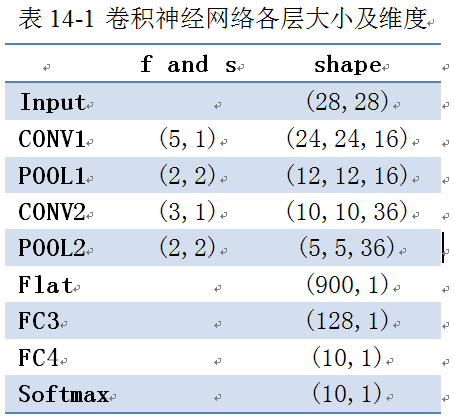

1.导入需要的包

In [3]:
import os
import struct
import numpy as np
import tensorflow as tf


2.自定义独热编码函数

In [4]:
def dense_to_one_hot(labels_dense, num_classes=10):
  """将类标签从标量转换为一个独热向量"""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


3.自定义下载函数

In [5]:
def load_mnist(path, kind='train'):
    """根据指定路径加载数据集"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        labels=dense_to_one_hot(labels)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)


    return images, labels


4.定义网络参数

In [6]:
#参数
learning_rate = 0.001
num_steps = 4000
batch_size = 128
display_step = 100

# 网络参数
n_input = 784 # MNIST输入数据维度 28*28)
n_classes = 10 # MNIST分类数
dropout = 0.80 # Dropout保留节点概率


5.导入数据

TensorFlow在样例教程中已经做了下载并导入MNIST数字手写体识别数据集的实现，可以直接使用。但运行时经常发生断网或无法下载的情况，这里我们采用先从http://yann.lecun.com/exdb/mnist 下载，然后把下载的4个文件放在本地当前目录的data/mnist目录下，具体实现请看如下代码。其中load_mnist函数请参考梯度下降及优化部分

In [7]:
X_train, y_train = load_mnist('./MNIST_data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Rows: %d, columns: %d' % ( y_train.shape[0],  y_train.shape[1]))

X_test, y_test = load_mnist('./MNIST_data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))


Rows: 60000, columns: 784
Rows: 60000, columns: 10
Rows: 10000, columns: 784


6.创建Dataset数据集

In [8]:
sess = tf.Session()

# 创建来自images and the labels的数据集张量
dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.astype(np.float32),y_train.astype(np.float32)))
# 对数据集进行批次划分
dataset = dataset.batch(batch_size)
# 在dataset创建迭代器
iterator = dataset.make_initializable_iterator()
# 使用两个占位符号( placeholders), 避免2G限制.
_data = tf.placeholder(tf.float32, [None, n_input])
_labels = tf.placeholder(tf.float32, [None, n_classes])
# 初始化迭代器
sess.run(iterator.initializer, feed_dict={_data: X_train.astype(np.float32),
                                          _labels: y_train.astype(np.float32)})

#获取输入值
X, Y = iterator.get_next()


7.创建模型

在MNIST数据集中，原始的28*28像素的黑白图片被展平为784维的向量

In [10]:
# 创建模型
def conv_net(x, n_classes, dropout, reuse, is_training):
    # 定义可复用参数的范围
    with tf.variable_scope('ConvNet', reuse=reuse):
        # 利用Reshape函数把输入由1维变为4维标量
        # 4维标量[Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # 定义卷积层1，共16 filters 核大小5x5
        conv1 = tf.layers.conv2d(x, 16, 5, activation=tf.nn.relu)
        # 定义最大池化层strides为2 核大小为2x2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # 定义卷积层1，共36 filters 核大小3x3
        conv2 = tf.layers.conv2d(conv1, 36, 3, activation=tf.nn.relu)
        # 定义最大池化层strides为2 核大小为2x2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # 定义全连接层
        fc1 = tf.layers.dense(fc1, 128)
        # 定义dropout层
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # 输出层
        out = tf.layers.dense(fc1, n_classes)
        # 使用softmax对输出进行分类
        out = tf.nn.softmax(out) if not is_training else out

    return out


8.训练及评估模型

由于Dropout 对训练集和测试集作用不同，我们创建两个计算图,它们可共享参数

In [11]:
# 创建为训练使用的计算图
logits_train = conv_net(X, n_classes, dropout, reuse=False, is_training=True)
# 创建为测试使用的计算图，它可复用参数，但不实施dropout操作
logits_test = conv_net(X, n_classes, dropout, reuse=True, is_training=False)

# 定义代价函数及选择优化器
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# 评估模型，但不执行dropout
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 初始化参数
init = tf.global_variables_initializer()

sess.run(init)

for step in range(1, num_steps + 1):

    try:
        #训练模型
        sess.run(train_op)
    except tf.errors.OutOfRangeError:
        # 当读到数据集尾部时，重载迭代器
        sess.run(iterator.initializer,
                 feed_dict={_data: X_train.astype(np.float32),
                            _labels: y_train.astype(np.float32)})
        sess.run(train_op)

    if step % display_step == 0 or step == 1:
        # 计算批量代价函数及精度
        # 这里读取批次数据不同
        loss, acc = sess.run([loss_op, accuracy])
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("优化结束!")


Step 1, Minibatch Loss= 84.8612, Training Accuracy= 0.125
Step 100, Minibatch Loss= 1.6119, Training Accuracy= 0.844
Step 200, Minibatch Loss= 0.6916, Training Accuracy= 0.938
Step 300, Minibatch Loss= 0.3321, Training Accuracy= 0.977
Step 400, Minibatch Loss= 0.3293, Training Accuracy= 0.969
Step 500, Minibatch Loss= 0.3120, Training Accuracy= 0.953
Step 600, Minibatch Loss= 0.4241, Training Accuracy= 0.938
Step 700, Minibatch Loss= 0.4180, Training Accuracy= 0.922
Step 800, Minibatch Loss= 0.1873, Training Accuracy= 0.969
Step 900, Minibatch Loss= 0.2144, Training Accuracy= 0.969
Step 1000, Minibatch Loss= 0.2246, Training Accuracy= 0.953
Step 1100, Minibatch Loss= 0.2075, Training Accuracy= 0.961
Step 1200, Minibatch Loss= 0.1522, Training Accuracy= 1.000
Step 1300, Minibatch Loss= 0.1998, Training Accuracy= 0.977
Step 1400, Minibatch Loss= 0.1519, Training Accuracy= 0.969
Step 1500, Minibatch Loss= 0.2100, Training Accuracy= 0.969
Step 1600, Minibatch Loss= 0.1657, Training Accurac